In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import equinox as eqx
import diffrax as dfx
import seaborn as sns

sns.set_theme(style="darkgrid")
palette = "viridis"
sns.set_palette(palette)

In [3]:
from model import *

In [4]:
def sample_traj(system):
    t0 = 0.0
    t1 = 40.0
    dt = 0.04
    tprev = t0
    tnext = t0 + dt


    solver = dfx.Tsit5()
    term = dfx.ODETerm(system.term)
    (x_init, s_init, e_init) = system.reset()
    obs = jnp.array([jnp.sin(x_init[0][0]), jnp.cos(x_init[0][0]), x_init[0][1],
                     jnp.sin(x_init[0][2]), jnp.cos(x_init[0][2]), x_init[0][3],
                     s_init[0][5], s_init[0][7], e_init[0][0]])
    z_init = system.produce_z(obs)
    y = (x_init[0], z_init, s_init[0], e_init[0])
    args = None
    state = solver.init(term, tprev, tnext, y, args)
    cumulutive_resources = []
    ss=[]
    zs=[]
    while tprev < t1:
        y, _, _, state, _ = solver.step(term, tprev, tnext, y, args, state, made_jump=False)
        tprev = tnext
        tnext = min(t1, tprev+dt)
        cumulutive_resources.append(y[3])
        ss.append(y[2])
        zs.append(y[1])
    return cumulutive_resources,ss,zs

In [5]:
seeds=[2,4,6,8]
systems= []
learned_systems =[]
for seed in seeds:
    system = BigField(num_neurons=40,seed=seed,num_obs=9)
    learned_system = eqx.tree_deserialise_leaves('./models/epoch_1814seed_2val10.393508191545337.eqx' ,system)
    systems.append(system)
    learned_systems.append(learned_system)

self.steepness:  -7.0
self.steepness:  -7.0
self.steepness:  -7.0
self.steepness:  -7.0


In [6]:
crs = [] # array of cumulutive resources for different seeds, shape = (num_seeds, num_timesteps)
sss = [] # array of s for different seeds, shape = (num_seeds, num_timesteps, num_s)
zzs = [] # array of z for different seeds, shape = (num_seeds, num_timesteps, num_z)
for i in range(len(seeds)):
    cr,ss,zs = sample_traj(learned_systems[i])
    crs.append(cr)
    sss.append(ss)
    zzs.append(zs)


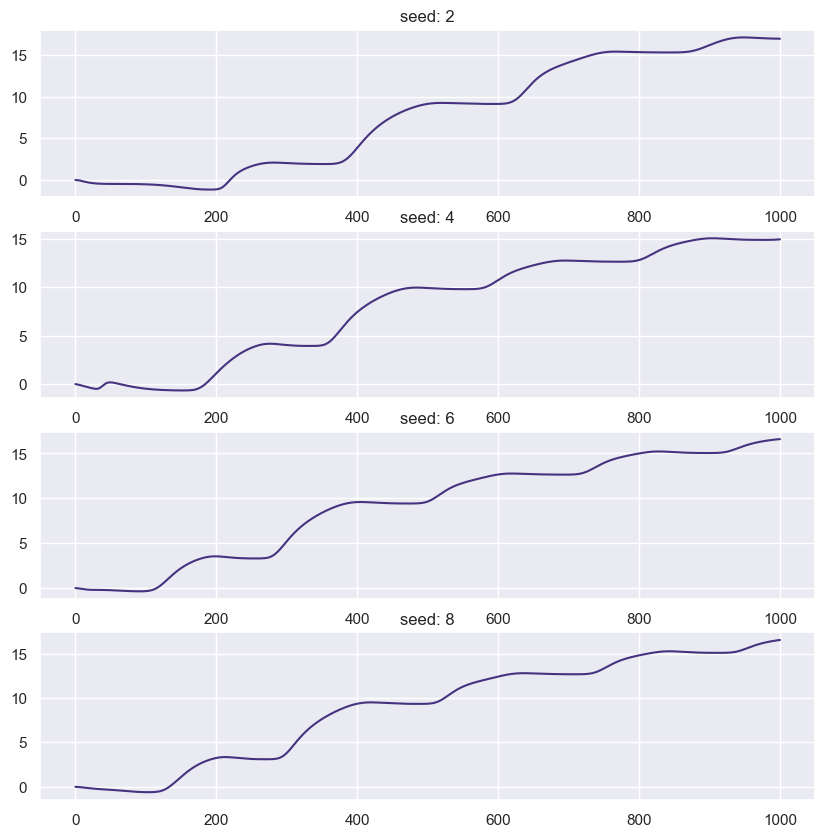

In [7]:
fig, ax = plt.subplots(nrows=len(seeds), ncols=1, figsize=(10, 10))
for i in range(len(seeds)):
    ax[i].plot(crs[i])
    ax[i].set_title('seed: {}'.format(seeds[i]))
plt.show()

In [8]:
def patch_arrival(ss):
    patch_arrival_times = []
    ss = jnp.array(ss)
    ss0 = ss[:,0]
    ss1 = ss[:,1]
    flag0 = False
    flag1 = False
    for i in range(len(ss0)-1):
        if ss0[i+1] < ss0[i] and flag0 == False:
            patch_arrival_times.append(i)
            flag0 = True
        elif ss0[i+1] > ss0[i]:
            flag0 = False
        if ss1[i+1] < ss1[i] and flag1 == False:
            patch_arrival_times.append(i)
            flag1 = True
        elif ss1[i+1] > ss1[i]:
            flag1 = False
    #print(patch_arrival_times)
    return patch_arrival_times

def patch_departure(ss0, ss1):
    patch_departure_times = []
    flag0 = True
    flag1 = True
    for i in range(len(ss0)-1):
        if ss0[i+1] > ss0[i] and flag0 == False:
            patch_departure_times.append(i)
            flag0 = True
        elif ss0[i+1] < ss0[i]:
            flag0 = False
        if ss1[i+1] > ss1[i] and flag1 == False:
            patch_departure_times.append(i)
            flag1 = True
        elif ss1[i+1] < ss1[i]:
            flag1 = False
    #print(patch_departure_times)
    return patch_departure_times

In [9]:
crs_np = []
sss_np = []
zss_np = []
for i in range(len(seeds)):
    crs_np.append(jnp.array(crs[i]))
    sss_np.append(jnp.array(sss[i]))
    zss_np.append(jnp.array(zzs[i]))

In [10]:
#calculate the patch arrival and departure times for different seeds
patch_arrival_times = [] # shape = (num_seeds, num_visits)
patch_departure_times = []
for i in range(len(seeds)):
    patch_arrival_times.append(patch_arrival(sss_np[i]))
    patch_departure_times.append(patch_departure(sss_np[i][:,0],sss_np[i][:,1]))

print(patch_arrival_times)
print(patch_departure_times)

[[200, 367, 609, 866], [29, 166, 347, 572, 791, 996], [103, 269, 490, 711, 915], [115, 283, 504, 727, 929]]
[[275, 519, 765, 948], [52, 281, 486, 697, 911], [203, 406, 621, 834], [217, 421, 638, 849]]


In [11]:
#consider only 4 patch arrival and departure per seed
for i in range(len(seeds)):
    patch_arrival_times[i] = patch_arrival_times[i][:4]
    patch_departure_times[i] = patch_departure_times[i][:4]
print(patch_arrival_times)
print(patch_departure_times)

[[200, 367, 609, 866], [29, 166, 347, 572], [103, 269, 490, 711], [115, 283, 504, 727]]
[[275, 519, 765, 948], [52, 281, 486, 697], [203, 406, 621, 834], [217, 421, 638, 849]]


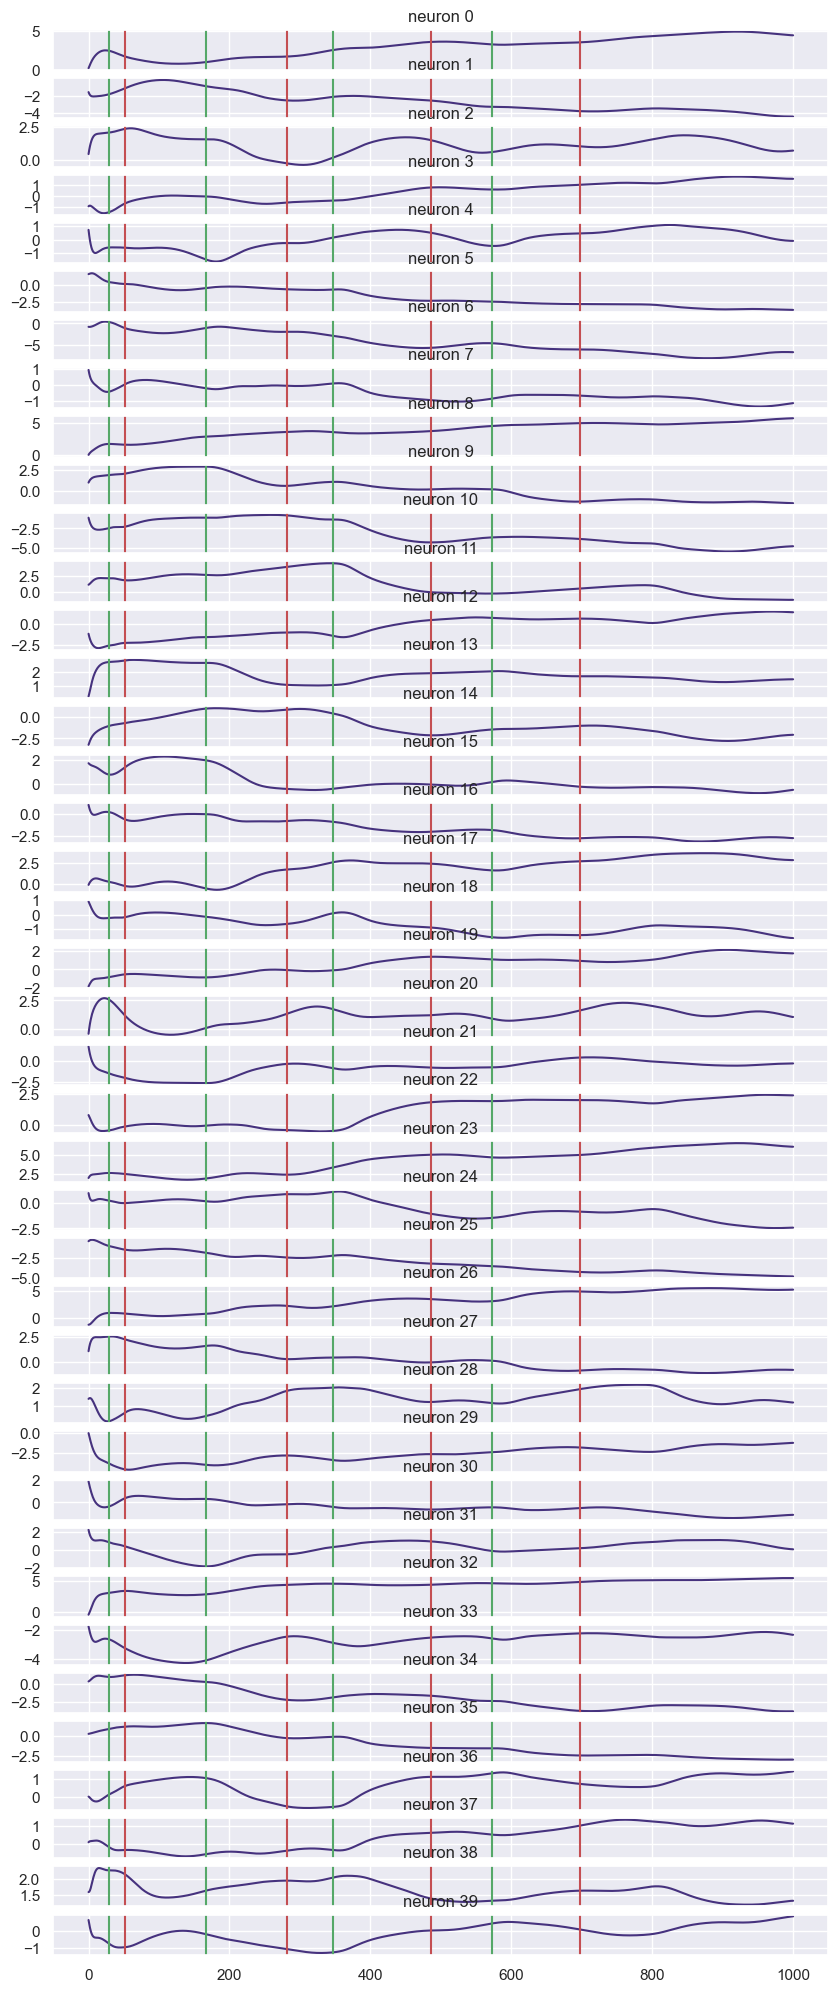

In [12]:
fig,ax = plt.subplots(nrows = 40, ncols=1, figsize=(10,25))
good_neurons = [0,1,2,3,4,5,6,7,8,9,
                10,11,12,13,14,15,16,17,18,19,
                20,21,22,23,24,25,26,27,28,29,
                30,31,32,33,34,35,36,37,38,39]
for i in range(len(good_neurons)):
    ax[i].plot(zss_np[1][:,good_neurons[i]])
    ax[i].set_title('neuron {}'.format(good_neurons[i]))
    for j in patch_arrival_times[1]:
        ax[i].axvline(j,color='g')
    for j in patch_departure_times[1]:
        ax[i].axvline(j,color='r')

In [13]:
#first 3 patch arrival and departure times
patch_arrival_times = jnp.array(patch_arrival_times)
patch_departure_times = jnp.array(patch_departure_times)
print(patch_arrival_times)
print(patch_departure_times)
first_patch_residal_times = []
for i in range(len(seeds)):
    print("patch arrival time: {}".format(patch_arrival_times[i,1]))
    print("patch departure time: {}".format(patch_departure_times[i,1]))
    first_patch_residal_times.append(patch_departure_times[i,1]-patch_arrival_times[i,1])
print(first_patch_residal_times)

[[200 367 609 866]
 [ 29 166 347 572]
 [103 269 490 711]
 [115 283 504 727]]
[[275 519 765 948]
 [ 52 281 486 697]
 [203 406 621 834]
 [217 421 638 849]]
patch arrival time: 367
patch departure time: 519
patch arrival time: 166
patch departure time: 281
patch arrival time: 269
patch departure time: 406
patch arrival time: 283
patch departure time: 421
[Array(152, dtype=int64), Array(115, dtype=int64), Array(137, dtype=int64), Array(138, dtype=int64)]


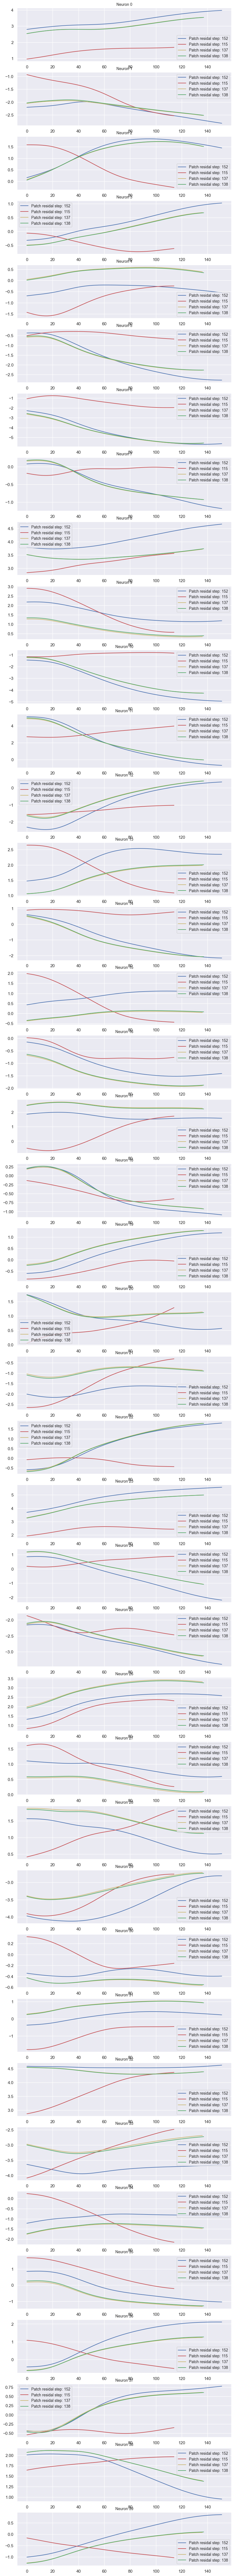

In [14]:
fig, ax = plt.subplots(nrows = 40, ncols=1, figsize=(10,120))

for i in range(40):
    ax[i].plot(zss_np[0][patch_arrival_times[0,1]:patch_departure_times[0,1],good_neurons[i]], label='Patch residal step: {}'.format(first_patch_residal_times[0]), color='b')
    ax[i].plot(zss_np[1][patch_arrival_times[1,1]:patch_departure_times[1,1],good_neurons[i]], label='Patch residal step: {}'.format(first_patch_residal_times[1]), color='r')
    ax[i].plot(zss_np[2][patch_arrival_times[2,1]:patch_departure_times[2,1],good_neurons[i]], label='Patch residal step: {}'.format(first_patch_residal_times[2]), color='y')
    ax[i].plot(zss_np[3][patch_arrival_times[3,1]:patch_departure_times[3,1],good_neurons[i]], label='Patch residal step: {}'.format(first_patch_residal_times[3]), color='g')
    ax[i].set_title('Neuron {}'.format(good_neurons[i]), fontsize = 10)
    ax[i].legend(fontsize=10)


plt.show()
#plt.savefig('patch_residal_times.svg', bbox_inches='tight')


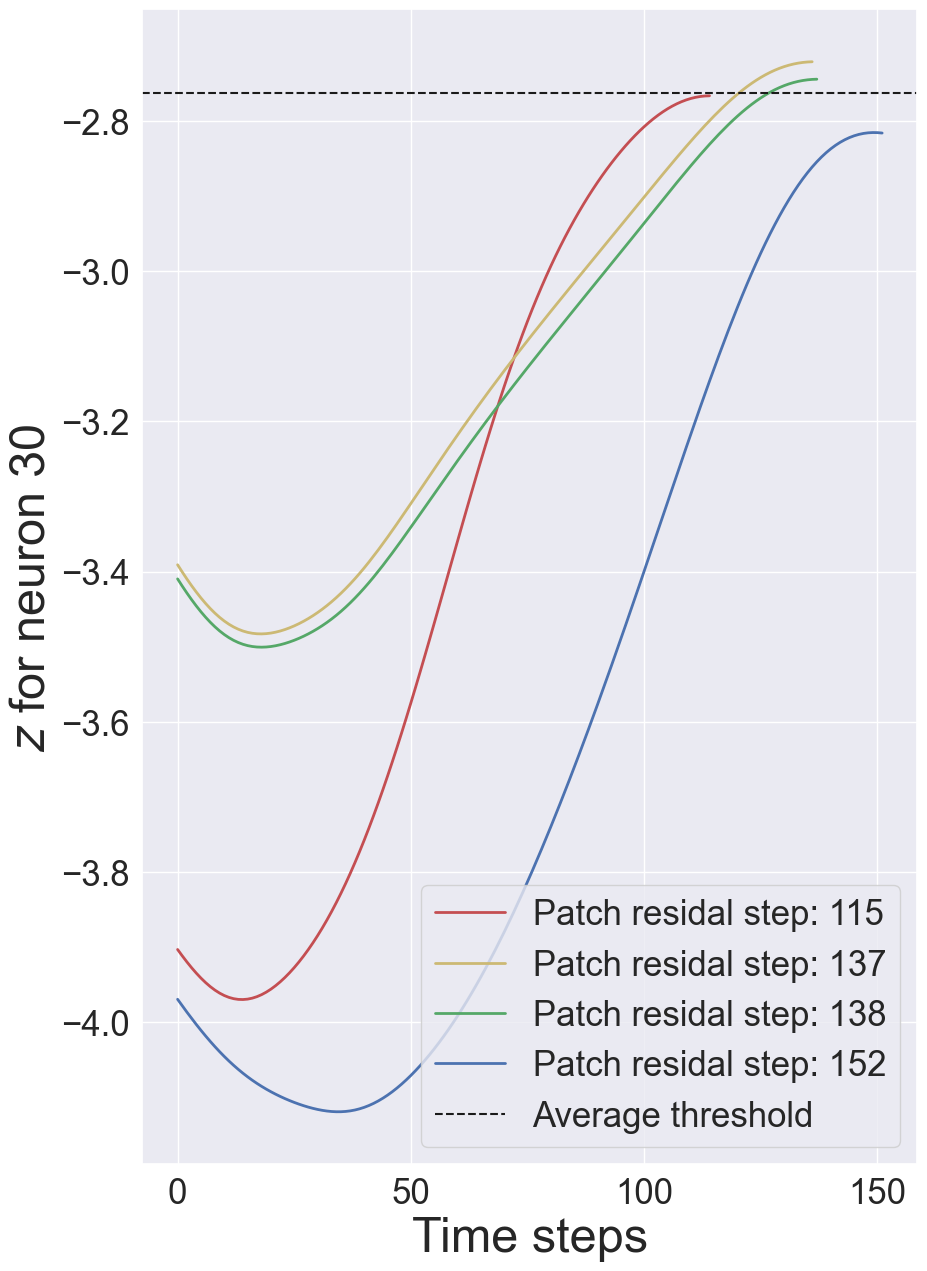

In [19]:
slope_neuron = [29]
thresh_neuron = [0,23]
fig, ax = plt.subplots(figsize=(10,15))

ax.plot(zss_np[1][patch_arrival_times[1,1]:patch_departure_times[1,1],slope_neuron[0]], label='Patch residal step: {}'.format(first_patch_residal_times[1]), color='r', linewidth=2)
ax.plot(zss_np[2][patch_arrival_times[2,1]:patch_departure_times[2,1],slope_neuron[0]], label='Patch residal step: {}'.format(first_patch_residal_times[2]), color='y', linewidth=2)
ax.plot(zss_np[3][patch_arrival_times[3,1]:patch_departure_times[3,1],slope_neuron[0]], label='Patch residal step: {}'.format(first_patch_residal_times[3]), color='g', linewidth=2)
ax.plot(zss_np[0][patch_arrival_times[0,1]:patch_departure_times[0,1],slope_neuron[0]], label='Patch residal step: {}'.format(first_patch_residal_times[0]), color='b', linewidth=2)
ax.set_ylabel('$z$ for neuron {}'.format(slope_neuron[0]+1), fontsize = 35)
ax.set_xlabel('Time steps', fontsize = 35)

final_z_values = [zss_np[0][patch_departure_times[0,1],slope_neuron[0]],zss_np[1][patch_departure_times[1,1],slope_neuron[0]],zss_np[2][patch_departure_times[2,1],slope_neuron[0]],zss_np[3][patch_departure_times[3,1],slope_neuron[0]]]
final_z_values = jnp.array(final_z_values)
average_threshold = jnp.mean(final_z_values)
ax.axhline(average_threshold, color='k', linestyle='--', label='Average threshold')
ax.tick_params(axis='both', which='major', labelsize=25)
ax.legend(fontsize=25)
plt.xticks([0,50,100,150])
plt.savefig('diff_slopes.svg', bbox_inches='tight')
plt.show()



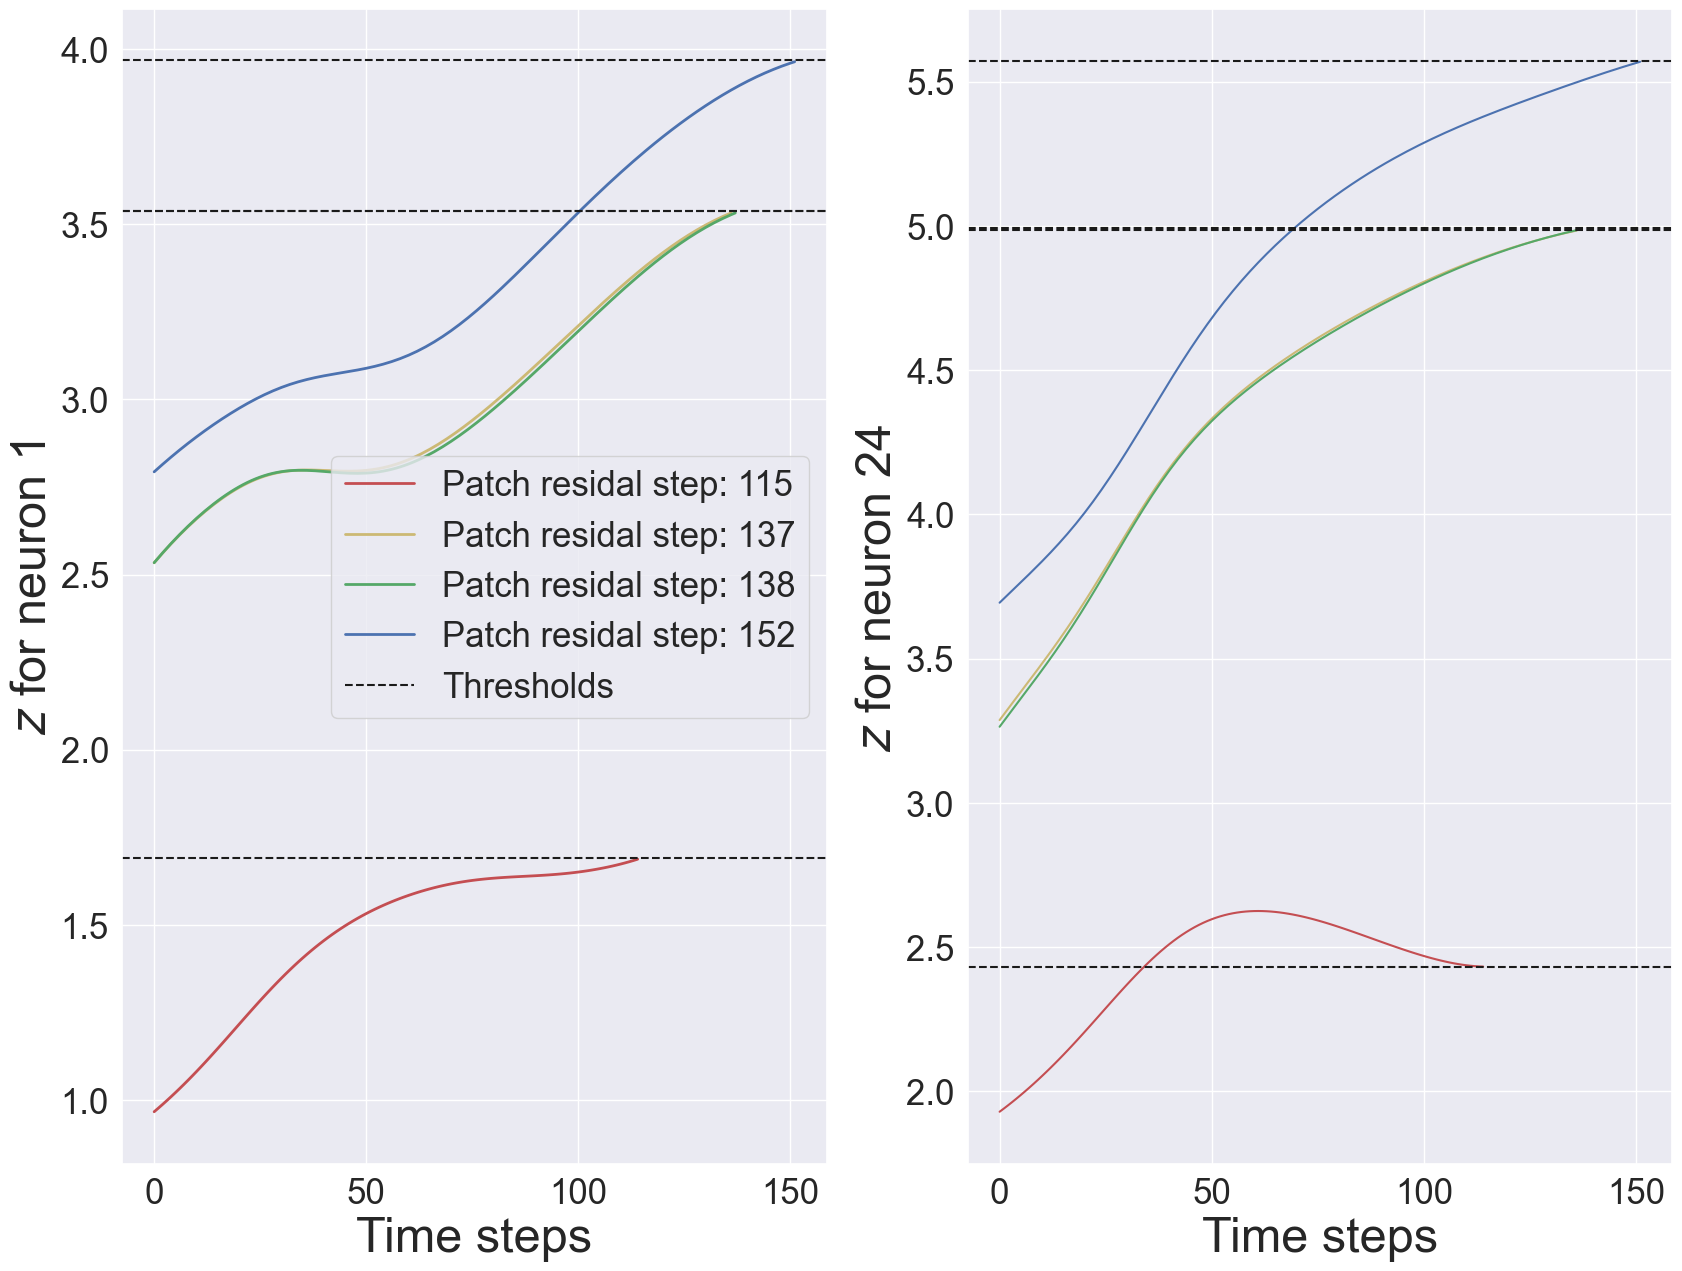

In [23]:
fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(20,15))

ax[0].plot(zss_np[1][patch_arrival_times[1,1]:patch_departure_times[1,1],thresh_neuron[0]], label='Patch residal step: {}'.format(first_patch_residal_times[1]), color='r', linewidth=2)
ax[0].plot(zss_np[2][patch_arrival_times[2,1]:patch_departure_times[2,1],thresh_neuron[0]], label='Patch residal step: {}'.format(first_patch_residal_times[2]), color='y', linewidth=2)
ax[0].plot(zss_np[3][patch_arrival_times[3,1]:patch_departure_times[3,1],thresh_neuron[0]], label='Patch residal step: {}'.format(first_patch_residal_times[3]), color='g', linewidth=2)
ax[0].plot(zss_np[0][patch_arrival_times[0,1]:patch_departure_times[0,1],thresh_neuron[0]], label='Patch residal step: {}'.format(first_patch_residal_times[0]), color='b', linewidth=2)
ax[0].set_ylabel('$z$ for neuron {}'.format(thresh_neuron[0]+1), fontsize = 35)
ax[0].set_xlabel('Time steps', fontsize = 35)
red_thresh = zss_np[1][patch_departure_times[1,1],thresh_neuron[0]]
yellow_thresh = zss_np[2][patch_departure_times[2,1],thresh_neuron[0]]
green_thresh = zss_np[3][patch_departure_times[3,1],thresh_neuron[0]]
blue_thresh = zss_np[0][patch_departure_times[0,1],thresh_neuron[0]]
ax[0].axhline(red_thresh, color='k', linestyle='--', label='Thresholds')
ax[0].axhline(yellow_thresh, color='k', linestyle='--')
ax[0].axhline(green_thresh, color='k', linestyle='--')
ax[0].axhline(blue_thresh, color='k', linestyle='--')
ax[0].legend(fontsize=25, loc='center right')
ax[0].tick_params(axis='both', which='major', labelsize=25)





ax[1].plot(zss_np[0][patch_arrival_times[0,1]:patch_departure_times[0,1],thresh_neuron[1]], label='Patch residal step: {}'.format(first_patch_residal_times[0]), color='b')
ax[1].plot(zss_np[1][patch_arrival_times[1,1]:patch_departure_times[1,1],thresh_neuron[1]], label='Patch residal step: {}'.format(first_patch_residal_times[1]), color='r')
ax[1].plot(zss_np[2][patch_arrival_times[2,1]:patch_departure_times[2,1],thresh_neuron[1]], label='Patch residal step: {}'.format(first_patch_residal_times[2]), color='y')
ax[1].plot(zss_np[3][patch_arrival_times[3,1]:patch_departure_times[3,1],thresh_neuron[1]], label='Patch residal step: {}'.format(first_patch_residal_times[3]), color='g')
ax[1].set_ylabel('$z$ for neuron {}'.format(thresh_neuron[1]+1), fontsize = 35)
ax[1].set_xlabel('Time steps', fontsize = 35)
red_thresh = zss_np[1][patch_departure_times[1,1],thresh_neuron[1]]
yellow_thresh = zss_np[2][patch_departure_times[2,1],thresh_neuron[1]]
green_thresh = zss_np[3][patch_departure_times[3,1],thresh_neuron[1]]
blue_thresh = zss_np[0][patch_departure_times[0,1],thresh_neuron[1]]
ax[1].axhline(red_thresh, color='k', linestyle='--', label='Thresholds')
ax[1].axhline(yellow_thresh, color='k', linestyle='--')
ax[1].axhline(green_thresh, color='k', linestyle='--')
ax[1].axhline(blue_thresh, color='k', linestyle='--')
ax[1].tick_params(axis='both', which='major', labelsize=25)


plt.savefig('diff_thresh.svg', bbox_inches='tight')
plt.show()